# Practical 7: Function Approximation

In [1]:
import random
import collections
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as disp

import rldurham as rld

rld.seed_everything(42)
if torch.cuda.is_available():
    print('It is recommended to train on the CPU for this')

Seed set to 42


It is recommended to train on the CPU for this


# Some helper functions for environments

In [2]:
env = rld.make('CartPole-v1')              # easy discrete
# env = rld.make("LunarLander-v2")           # discrete
# env = rld.make('Breakout-v0')              # discrete
# env = rld.make("Pong-ram-v0")              # discrete
# env = rld.make("Gravitar-ram-v0")          # hard discrete
#
# env = rld.make("Pendulum-v0")              # easy continuous
# env = rld.make("BipedalWalker-v3")         # continuous
# env = rld.make("LunarLanderContinuous-v2") # continuous
# env = rld.make("BipedalWalkerHardcore-v3") # hard continuous
rld.env_info(env, print_out=True)

actions are discrete with 2 dimensions/#actions
observations are continuous with 4 dimensions/#observations
maximum timesteps is: 500


(True, False, np.int64(2), 4)

# Plotting

Tracking and plotting multiple values over multiple experiments

In [3]:
class Plotter:

    # data are over different 'outer' functions and multiple episodes
    TrackedValue = collections.namedtuple("TrackedValue", "inner outer data")

    def __init__(self, plot_interval=1, line_styles=("-", "--", "-.", ":"), multicol=False):
        # parameters
        self.plot_interval = plot_interval
        self.line_styles = line_styles
        self.multicol = multicol
        # track values over multiple episodes
        self.ep_vals = {}      # a dict with current values in episode (updated using 'inner')
        self.ep_val_lists = {} # a dict with values from multiple past episdes
        self.track_auc = {}    # whether to track AUCs for different values (dict)
        self.inner_func = {}   # inner function for different values (dict)
        self.outer_func = {}   # outer function(s) for different values (dict)
        # remember info from multiple experiments
        self.trace_values = []# a list of dicts of dict of trace values
        self.plot_data = []   # a list of dicts of TrackedValues
        self.plot_labels = [] # a list of labels

    def _set_dict(self, d, k, v):
        if k not in d:
            d[k] = v
        elif d[k] != v:
            raise ValueError(f"Value '{v}' for key '{k}' conflicts with stored value '{d[k]}'")

    def track(self, inner="sum", outer="mean", auc=False, **kwargs):
        for k, v in kwargs.items():
            if inner == "sum":
                if k not in self.ep_vals:
                    self.ep_vals[k] = 0
                self.ep_vals[k] += v
            elif inner == "min":
                if k not in self.ep_vals:
                    self.ep_vals[k] = v
                self.ep_vals[k] = min(self.ep_vals[k], v)
            elif inner == "max":
                if k not in self.ep_vals:
                    self.ep_vals[k] = v
                self.ep_vals[k] = max(self.ep_vals[k], v)
            elif inner == "mean":
                if k not in self.ep_vals:
                    self.ep_vals[k] = np.array([0., 0.])
                self.ep_vals[k] += [v, 1]
            else:
                raise ValueError(f"Tracking function '{inner}' is not implemented")
            self._set_dict(self.inner_func, k, inner)
            self._set_dict(self.outer_func, k, outer)
            self._set_dict(self.track_auc, k, auc)

    def track_trace_value(self, key, **kwargs):
        if key not in self.trace_values[-1]:
            self.trace_values[-1][key] = {}
        for k, v in kwargs.items():
            self.trace_values[-1][key][k] = v

    def finish_episode(self, episode, plot=None, condense=None):
        for k, v in self.ep_vals.items():
            if k not in self.ep_val_lists:
                self.ep_val_lists[k] = []
            if self.inner_func[k] == "mean":
                v = v[0] / v[1]
            self.ep_val_lists[k].append(v)
            if self.track_auc[k]:
                if k not in self.trace_values[-1]:
                    self.trace_values[-1][k] = {}
                if 'auc' not in self.trace_values[-1][k]:
                    self.trace_values[-1][k]['auc'] = 0
                self.trace_values[-1][k]['auc'] += v
        self.ep_vals = {}
        interval_match = episode % self.plot_interval == 0
        if condense or (condense is None and interval_match):
            self.condense_episode(episode)
        if plot or (plot is None and interval_match):
            self.plot()
        return interval_match

    def condense_episode(self, episode):
        for k, v in self.ep_val_lists.items():
            new_data = [episode]
            outer_funcs = []
            for func in self.outer_func[k].split("|"):
                outer_funcs.append(func)
                if func == "mean":
                    new_data.append(np.array(v).mean())
                elif func == "min":
                    new_data.append(np.array(v).min())
                elif func == "max":
                    new_data.append(np.array(v).max())
                elif func == "std":
                    new_data.append(np.array(v).std())
                else:
                    raise ValueError(f"Outer function '{func}' not implemented")
            if k not in self.plot_data[-1]:
                self.plot_data[-1][k] = self.TrackedValue(inner=self.inner_func[k],
                                                          outer=outer_funcs,
                                                          data=[])
            self.plot_data[-1][k].data.append(new_data)
        self.ep_val_lists = {}

    def plot(self, show=True):
        fig = plt.figure()
        for ex_data, ex_trace_values, ex_label in zip(self.plot_data,
                                              self.trace_values,
                                              self.plot_labels):
            # if not self.multicol:
            #     # color=next(plt.gca()._get_lines.prop_cycler)['color']
            #     # ls_cycle = itertools.cycle(self.line_styles)
            # else:
            #     plt.gca().set_prop_cycle(None)
            for value_name, tracked_value in ex_data.items():
                # if self.multicol:
                #     # color=next(plt.gca()._get_lines.prop_cycler)['color']
                #     # ls_cycle = itertools.cycle(self.line_styles)
                d = tracked_value.data
                for idx, outer in enumerate(tracked_value.outer):
                    # ls = next(ls_cycle)
                    label = "" if ex_label is None else f"{ex_label}: "
                    label += f"{value_name}-{tracked_value.inner}-{outer}"
                    if outer == "std":
                        plt.fill_between([x[0] for x in d],
                                         [x[idx] - x[idx + 1] for x in d],
                                         [x[idx] + x[idx + 1] for x in d],
                                         alpha=0.05,
                                         # color=color
                                        )
                    else:
                        tv_label = ""
                        if value_name in ex_trace_values:
                            for k, v in ex_trace_values[value_name].items():
                                if tv_label:
                                    tv_label += ", "
                                if k == 'auc':
                                    tv_label += f"AUC={np.format_float_scientific(v, precision=1)}"
                                else:
                                    tv_label += f"{k}={v}"
                            if tv_label:
                                tv_label = f" ({tv_label})"
                        plt.plot([x[0] for x in d],
                                 [x[idx + 1] for x in d],
                                 '-',
                                 # color=color,
                                 # ls=ls,
                                 label=label+tv_label)
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.legend()
        disp.clear_output(wait=True)
        if show:
            plt.show()
        return fig

    def next_experiment(self, label=None):
        self.ep_vals = {}
        self.ep_val_lists = {}
        self.track_auc = {}
        self.inner_func = {}
        self.outer_func = {}
        self.trace_values.append({})
        self.plot_data.append({})
        self.plot_labels.append(label)

# Agents

## REINFORCE (CartPole)

In [4]:
class REINFORCE(nn.Module):
    def __init__(self, env):
        discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env)
        # discrete, obs_dim, act_dim = env_info(env, p=False)
        assert discrete_act, "REINFORCE only works for discrete action spaces"
        super().__init__()
        self.data = []
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, act_dim)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.00002)

    def __str__(self):
        return "REINFORCE"

    def print_params(self):
        return dict()

    def sample_action(self, state):
        x = F.relu(self.fc1(torch.from_numpy(state).float()))
        prob = F.softmax(self.fc2(x), dim=0)
        action = D.Categorical(prob).sample()
        return action.item(), torch.log(prob[action])

    def put_data(self, item):
        self.data.append(item)

    def train(self):
        R = 0
        self.optimizer.zero_grad()
        for _, _, r, _, _, log_prob in self.data[::-1]:
            R = r + 0.98 * R
            loss = -log_prob * R
            loss.backward()
        self.optimizer.step()
        self.data = []

## SAC (Pendulum)

In [5]:
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done, log_prob = transition
            s_lst.append(s)
            a_lst.append([a[0]])
            r_lst.append([0.1 * r]) ## TODO
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)

    def size(self):
        return len(self.buffer)

class SACPolicyNet(nn.Module):
    def __init__(self, learning_rate, init_alpha, lr_alpha):
        super().__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        self.log_alpha = torch.tensor(np.log(init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr_alpha)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = D.Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1-torch.tanh(action).pow(2) + 1e-7)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch, target_entropy):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

class QNet(nn.Module):
    def __init__(self, learning_rate):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64)
        self.fc_a = nn.Linear(1,64)
        self.fc_cat = nn.Linear(128,32)
        self.fc_out = nn.Linear(32,1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        loss = F.smooth_l1_loss(self.forward(s, a) , target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target, tau):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

class SAC(nn.Module):

    def __init__(self,
                 lr_pi           = 0.0005,
                 lr_q            = 0.001,
                 init_alpha      = 0.01,
                 gamma           = 0.98,
                 batch_size      = 32,
                 buffer_limit    = 50000,
                 tau             = 0.01,
                 target_entropy  = -1.0,
                 lr_alpha        = 0.001,
                 reward_scale    = 10,
                 action_scale    = 2,
                 raw=False):
        super().__init__()

#         self.raw = raw

        # hyperparameters
        self.lr_pi = lr_pi
        self.lr_q = lr_q
        self.init_alpha = init_alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer_limit = buffer_limit
        self.tau = tau  # for target network soft update
        self.target_entropy = target_entropy # for automated alpha update
        self.lr_alpha = lr_alpha # for automated alpha update
        self.reward_scale = reward_scale
        self.action_scale = action_scale


        self.memory = ReplayBuffer(buffer_limit)
        self.pi = SACPolicyNet(lr_pi, init_alpha, lr_alpha)
        self.q1 = QNet(lr_q)
        self.q2 = QNet(lr_q)
        self.q1_target = QNet(lr_q)
        self.q2_target = QNet(lr_q)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

    def __str__(self):
        return "SAC"

    def print_params(self):
        return dict(alpha=np.format_float_scientific(self.pi.log_alpha.exp(), precision=1))

    def sample_action(self, state):
        action, log_prob = self.pi(torch.from_numpy(state).float())
        return self.action_scale * action.detach().numpy(), log_prob

    def put_data(self, item):
        s, a, r, s_prime, done, log_prob = item
        r /= self.reward_scale
        a /= self.action_scale
        self.memory.put((s, a, r, s_prime, done, log_prob))

    def train(self):
        if self.memory.size() > 1000:
            for i in range(20):
                mini_batch = self.memory.sample(self.batch_size)
                td_target = self.calc_target(mini_batch, self.q1_target, self.q2_target)
                self.q1.train_net(td_target, mini_batch)
                self.q2.train_net(td_target, mini_batch)
                entropy = self.pi.train_net(self.q1, self.q2, mini_batch, self.target_entropy)
                self.q1.soft_update(self.q1_target, self.tau)
                self.q2.soft_update(self.q2_target, self.tau)

    def calc_target(self, mini_batch, q1_target, q2_target, alpha=None):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            a_prime, log_prob= self.pi(s_prime)
            if alpha is None:
                alpha = self.pi.log_alpha.exp()
            entropy = -alpha * log_prob
            q1_val, q2_val = q1_target(s_prime,a_prime), q2_target(s_prime,a_prime)
            q1_q2 = torch.cat([q1_val, q2_val], dim=1)
            min_q = torch.min(q1_q2, 1, keepdim=True)[0]
            target = r + self.gamma * done * (min_q + entropy)
        return target

# Experiments

In [6]:
def experiment(env, env_name, agent, plotter, max_episodes, seed=None):
    # initialse new plot trace
    plotter.next_experiment(f"{agent} on {env_name}")
    # training procedure
    for episode in range(1, max_episodes + 1):
        # reset environment and collect new episode
        state, _ = env.reset()
        done = False
        while not done:
            # select action
            action, log_prob = agent.sample_action(state)
            # take action in environment and get r and s'
            next_state, reward, term, trun, info = env.step(action)
            done = term or trun
            agent.put_data((state, action, reward, next_state, done, log_prob))
            state = next_state
            # track performance
            plotter.track(reward=reward, auc=True) # cumulative reward
            if isinstance(agent, SAC):
                alpha = np.format_float_scientific(agent.pi.log_alpha.exp().item(), precision=2)
                plotter.track_trace_value("reward", alpha=alpha)
                plotter.track_trace_value("reward",
                                          lr_pi=agent.lr_pi,
                                          lr_q=agent.lr_q,
                                          init_alpha=agent.init_alpha,
                                          tau=agent.tau,
                                          lr_alpha=agent.lr_alpha)
        # train agent and plot progress
        agent.train()
        plotter.finish_episode(episode)

## REINFORCE / CartPole

In [7]:
plotter = Plotter(plot_interval=10)

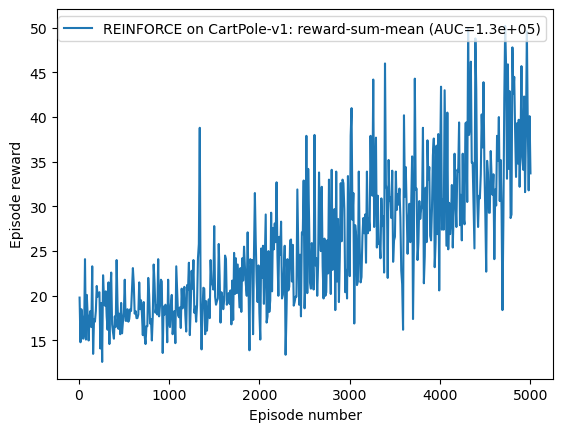

In [8]:
#######################
## REINFORCE / CartPole
#######################
env_name = 'CartPole-v1'              # easy discrete
# env_name = "LunarLander-v2"           # discrete
# env_name = 'Breakout-v0'              # discrete
# env_name = "Pong-ram-v0"              # discrete
# env_name = "Gravitar-ram-v0"          # hard discrete
env = rld.make(env_name)
agent = REINFORCE(env)
max_episodes = 5000

experiment(env, env_name, agent, plotter, max_episodes)

## Infinite-armed bandits

In [9]:
class Env(nn.Module):
    def __init__(self, locations, rewards, tolerances):
        self.locations = torch.tensor(locations)
        self.rewards = torch.tensor(rewards)
        self.covariances = torch.eye(self.locations.shape[-1]) * torch.tensor(tolerances)[:, None, None] ** 2

    def reward(self, loc):
        reward = 0
        d = loc[..., None, :] - self.locations
        x = -torch.einsum('...a,...ab,...b', d, torch.inverse(self.covariances), d)
        return (x.exp() * self.rewards).sum(dim=-1)

    def plot(self, n=200):
        x = torch.linspace(-1, 1, n)
        y = torch.linspace(-1, 1, n)
        grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
        locs = torch.dstack([grid_x, grid_y])
        z = self.reward(locs.reshape(-1, 2)[:, None, :]).reshape((n, n))
        plt.imshow(z.T, origin='lower', extent=(-1, 1, -1, 1))
        plt.axis('off')
        return plt.gcf(), plt.gca()

In [10]:
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_std  = nn.Linear(128, 2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        mu = self.fc_mu(x)
        cov = F.softplus(self.fc_std(x))
        cov = torch.eye(2) * cov[..., None]
        dist = D.MultivariateNormal(mu, cov)
        action = dist.rsample()
        return torch.tanh(state + action) - state

In [11]:
plotter = Plotter(plot_interval=100)

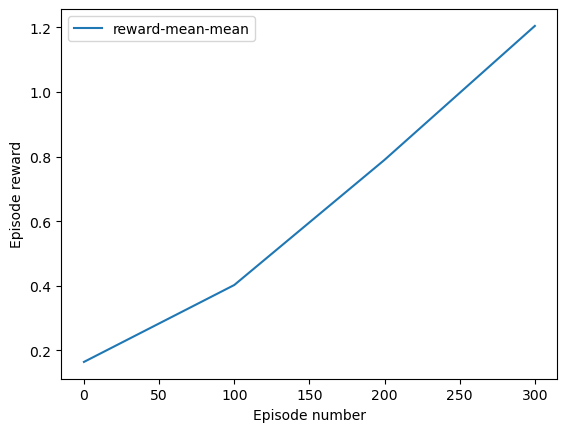

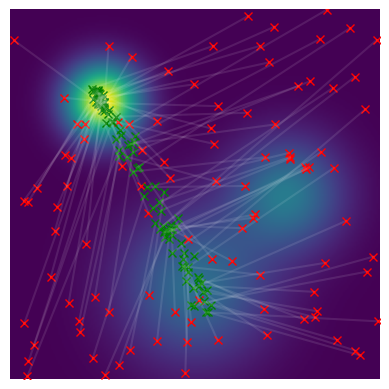

In [12]:
env = Env(locations=[[-0.5, 0.5], [0, -0.5], [0.5, 0]],
          rewards=[2.5, 0.9, 1.],
          tolerances=[0.2, 0.4, 0.3])
for ex in range(1):
    plotter.next_experiment()
    p = PolicyNet()
    optimizer = torch.optim.Adam(p.parameters(), lr=1e-3)
    n = 100
    n_ep = 301
    for ep in range(n_ep):
        # sample
        states = torch.rand((n, 2)) * 2 - 1
        actions = p(states)
        rewards = env.reward(states + actions)
        # train
        loss = -rewards.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # plot
        for r in rewards.detach().numpy():
            plotter.track(reward=r, inner='mean', outer='mean')
        if plotter.finish_episode(episode=ep):
            actions = actions.detach().numpy()
            fig, ax = env.plot()
            ax.plot(*states.T, 'rx')
            ax.plot(*(states + actions).T, 'gx')
            ax.plot(*torch.dstack([states, states + actions]).movedim((1,0), (0,2)), c=(1,1,1,0.1))
            plt.show()

## SAC / Pendulum

In [13]:
plotter = Plotter(plot_interval=10)

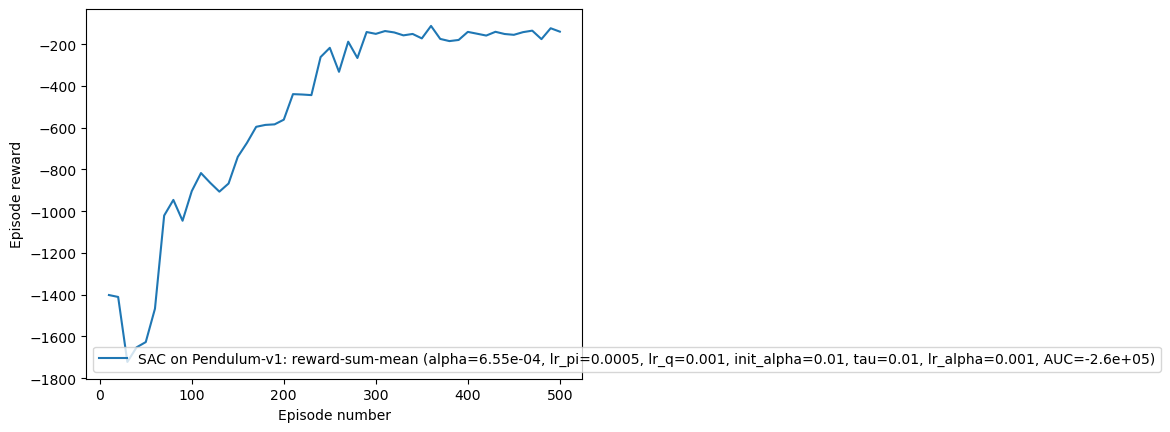

In [14]:
#################
## SAC / Pendulum
#################
env_name = "Pendulum-v1"              # easy continuous
# env_name = "BipedalWalker-v3"         # continuous
# env_name = "LunarLanderContinuous-v2" # continuous
# env_name = "BipedalWalkerHardcore-v3" # hard continuous
env = rld.make(env_name)
agent = SAC(lr_pi           = 0.0005, # learning rate for the policy (actor)
            lr_q            = 0.001,  # learning rate for the values (critic)
            init_alpha      = 0.01,   # initial exploration
            gamma           = 0.98,
            batch_size      = 32,
            buffer_limit    = 50000,
            tau             = 0.01,   # smoothing of value learning (lower is smoother)
            target_entropy  = -1.0,
            lr_alpha        = 0.001,  # learning rate for exploration
            reward_scale    = 10,
            action_scale    = 2)
max_episodes = 500
experiment(env, env_name, agent, plotter, max_episodes)